# Model: Logistic Regression

## Imports and Settings

In [1]:
# Helper libraries
import warnings
from itertools import combinations

# Scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, precision_score

# Local Imports
from churn_detection.utils import get_feature_names
from churn_detection.data import load_data
from churn_detection.visualization import plot_confusion_table
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.features import (InteractionStrengthExtractor,
                                      FeatureConcatenator, 
                                      RareCategoryEncoder)
from churn_detection.paths import PARENT_DIR
from churn_detection.config import load_config
from churn_detection.models.ml_pipeline import create_pipeline
from churn_detection.models.experiment import ExperimentManager


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading and Preparing Data

In [2]:
churn = load_data()

In [3]:
preprocessed_data = preprocess_data(churn)
numeric_variables, categorical_variables = get_feature_names(preprocessed_data)

In [4]:
extractor = InteractionStrengthExtractor("partner", "paymentmethod", ordinal_encode=True)
extractor.fit(preprocessed_data)

new_preprocessed_data = extractor.transform(preprocessed_data)
strength_feature = extractor.get_strength_col_name()

discrete_vars_pairs = list(combinations(categorical_variables, 2))
concat_transformer = FeatureConcatenator(feature_pairs=discrete_vars_pairs)
concat_preprocessed_data = concat_transformer.transform(new_preprocessed_data)

In [5]:
prep_train, prep_test = train_test_split(
        concat_preprocessed_data, 
        test_size=0.2, 
        random_state=1
)

X_train, y_train = split_data(prep_train)
X_test, y_test = split_data(prep_test)

In [6]:
continuous_set = numeric_variables + [strength_feature]
discrete_set = categorical_variables + concat_transformer.get_new_feature_names()

## Model Configuration and Thresholding

In [7]:
config_dir = PARENT_DIR / "configs"
config = load_config(config_dir / "config.yaml")

In [8]:
# Numeric Features Configuration
config["feature_engineering"]["params"]["numerical"]["variables"] = continuous_set
config["feature_engineering"]["params"]["numerical"]["steps"] = [("scaler", RobustScaler(quantile_range=(40, 60)))]

# Categorical Features Configuration
config["feature_engineering"]["params"]["categorical"]["variables"] = discrete_set
config["feature_engineering"]["params"]["categorical"]["steps"] = [
        ("rarecat", RareCategoryEncoder(tol=0.2)),
        ("catencoder", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"))
]

In [9]:
# Model Configuration
config["model"]["params"]["C"] = 100
config["model"]["params"]["max_iter"] = 100
config["model"]["params"]["penalty"] = "l1"
config["model"]["params"]["solver"] = "liblinear"

In [10]:
lr_pipeline = create_pipeline(config)

In [11]:
lr_pipeline.train(X_train, y_train)

In [21]:
from typing import Optional, Literal

def explore_thresholds(
    y_probs: np.ndarray,
    y_test: pd.Series,
    func: Literal["f1", "recall", "precision"],
    n_samples: int = 10,
    scores: bool = True,
    plot: Optional[bool] = None,
) -> None:
    metrics = {
        "f1": f1_score, 
        "recall": recall_score, 
        "precision": precision_score
    }
    
    thresholds = np.linspace(0, 1, n_samples)
    scores = []
    for thres in thresholds:
        churn = y_probs >= thres
        pred = metrics[func](y_test, churn)
        scores.append(pred)

        if scores:
            print(f"Threshold: {thres:.2f} - {func} Score: {pred:.3f}")

    if plot:
        plt.plot(thresholds, scores)
        plt.xlabel("Thresholds")
        plt.ylabel(f"{func}")
        plt.show()

In [13]:
y_probs = lr_pipeline.predict_proba(X_test)[:, 1]

Threshold: 0.00 - f1 Score: 0.396
Threshold: 0.03 - f1 Score: 0.462
Threshold: 0.06 - f1 Score: 0.502
Threshold: 0.10 - f1 Score: 0.523
Threshold: 0.13 - f1 Score: 0.551
Threshold: 0.16 - f1 Score: 0.563
Threshold: 0.19 - f1 Score: 0.578
Threshold: 0.23 - f1 Score: 0.584
Threshold: 0.26 - f1 Score: 0.594
Threshold: 0.29 - f1 Score: 0.602
Threshold: 0.32 - f1 Score: 0.600
Threshold: 0.35 - f1 Score: 0.601
Threshold: 0.39 - f1 Score: 0.601
Threshold: 0.42 - f1 Score: 0.602
Threshold: 0.45 - f1 Score: 0.605
Threshold: 0.48 - f1 Score: 0.614
Threshold: 0.52 - f1 Score: 0.598
Threshold: 0.55 - f1 Score: 0.590
Threshold: 0.58 - f1 Score: 0.571
Threshold: 0.61 - f1 Score: 0.557
Threshold: 0.65 - f1 Score: 0.520
Threshold: 0.68 - f1 Score: 0.478
Threshold: 0.71 - f1 Score: 0.425
Threshold: 0.74 - f1 Score: 0.365
Threshold: 0.77 - f1 Score: 0.301
Threshold: 0.81 - f1 Score: 0.197
Threshold: 0.84 - f1 Score: 0.087
Threshold: 0.87 - f1 Score: 0.017
Threshold: 0.90 - f1 Score: 0.006
Threshold: 0.9

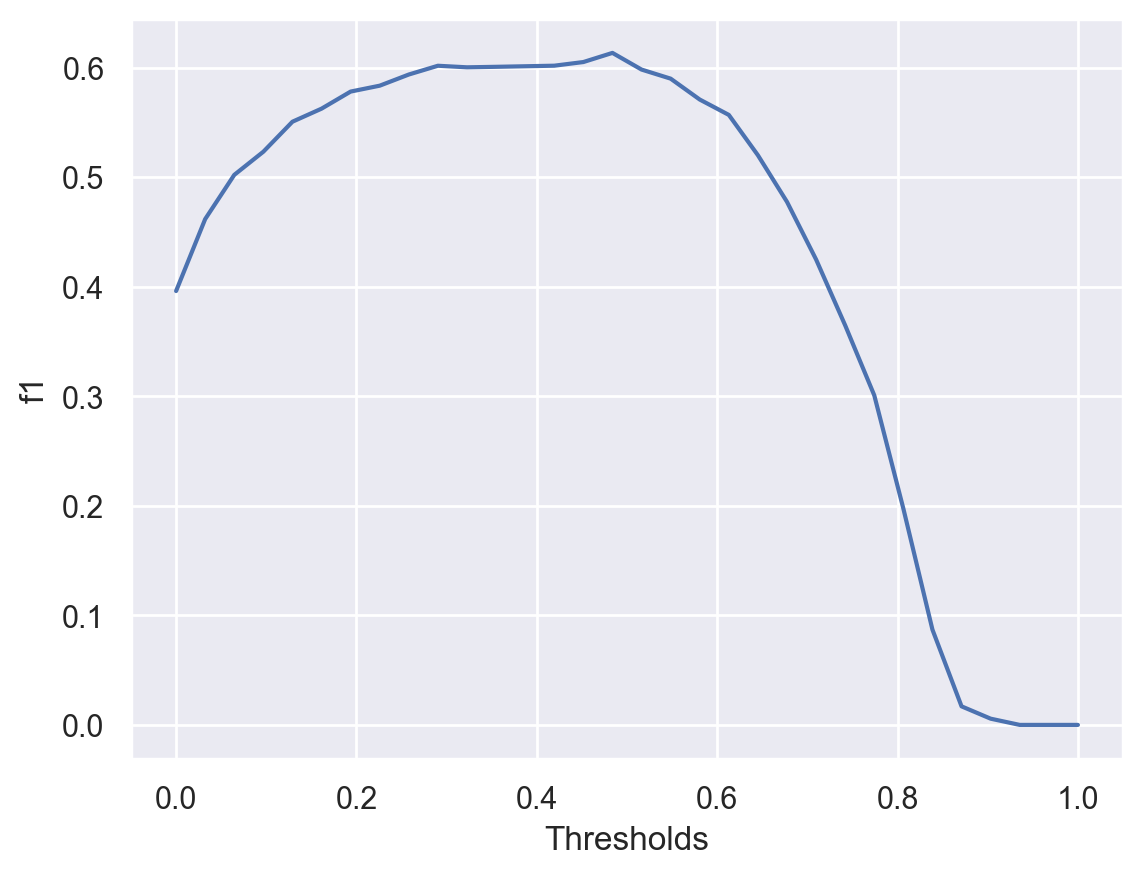

In [14]:
explore_thresholds(
    y_probs, 
    y_test, 
    func="f1", 
    n_samples=32, 
    plot=True
)

Threshold: 0.00 - recall Score: 1.000
Threshold: 0.03 - recall Score: 0.983
Threshold: 0.06 - recall Score: 0.977
Threshold: 0.10 - recall Score: 0.966
Threshold: 0.13 - recall Score: 0.951
Threshold: 0.16 - recall Score: 0.922
Threshold: 0.19 - recall Score: 0.902
Threshold: 0.23 - recall Score: 0.882
Threshold: 0.26 - recall Score: 0.859
Threshold: 0.29 - recall Score: 0.845
Threshold: 0.32 - recall Score: 0.816
Threshold: 0.35 - recall Score: 0.787
Threshold: 0.39 - recall Score: 0.750
Threshold: 0.42 - recall Score: 0.730
Threshold: 0.45 - recall Score: 0.698
Threshold: 0.48 - recall Score: 0.675
Threshold: 0.52 - recall Score: 0.629
Threshold: 0.55 - recall Score: 0.598
Threshold: 0.58 - recall Score: 0.549
Threshold: 0.61 - recall Score: 0.506
Threshold: 0.65 - recall Score: 0.445
Threshold: 0.68 - recall Score: 0.382
Threshold: 0.71 - recall Score: 0.313
Threshold: 0.74 - recall Score: 0.244
Threshold: 0.77 - recall Score: 0.187
Threshold: 0.81 - recall Score: 0.112
Threshold: 0

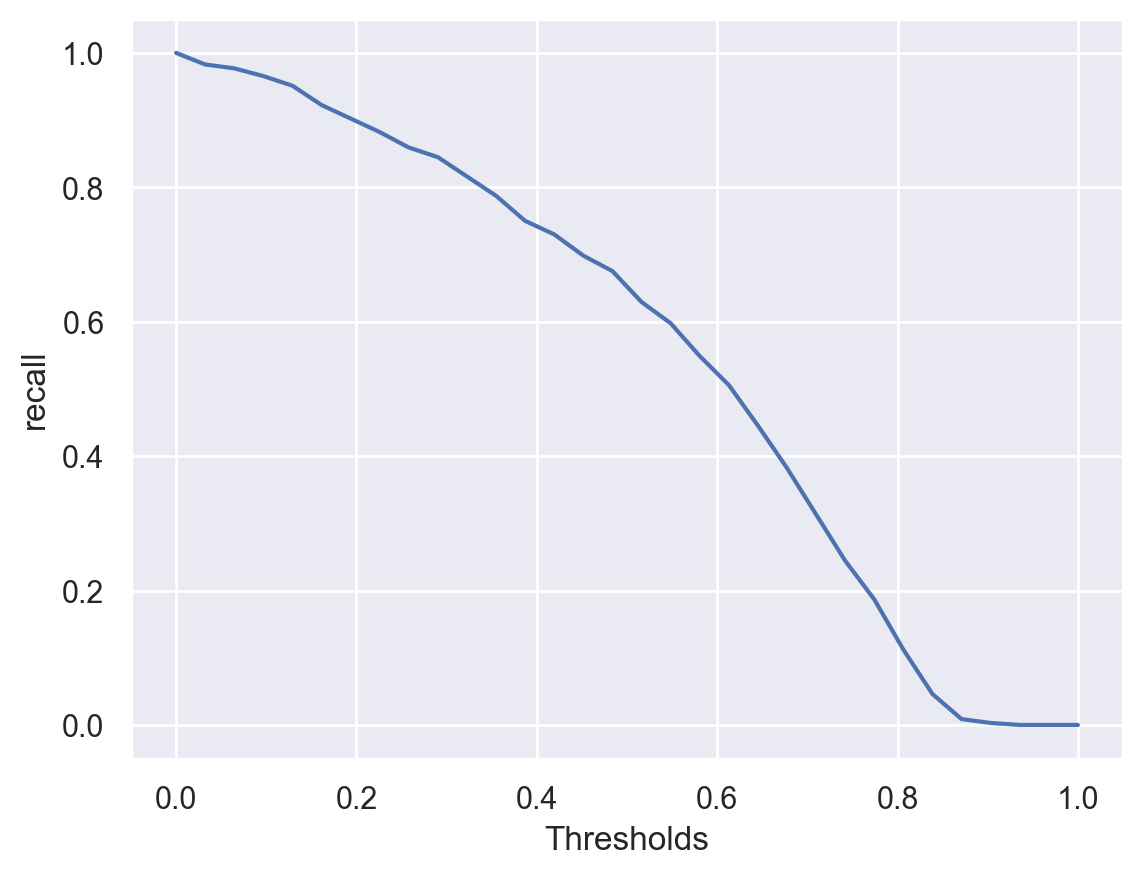

In [15]:
explore_thresholds(
    y_probs, 
    y_test, 
    func="recall", 
    n_samples=32, 
    plot=True
)

In [16]:
explore_thresholds(y_probs, y_test, func="precision", n_samples=32)

Threshold: 0.00 - precision Score: 0.247
Threshold: 0.03 - precision Score: 0.302
Threshold: 0.06 - precision Score: 0.338
Threshold: 0.10 - precision Score: 0.359
Threshold: 0.13 - precision Score: 0.388
Threshold: 0.16 - precision Score: 0.405
Threshold: 0.19 - precision Score: 0.425
Threshold: 0.23 - precision Score: 0.436
Threshold: 0.26 - precision Score: 0.454
Threshold: 0.29 - precision Score: 0.467
Threshold: 0.32 - precision Score: 0.475
Threshold: 0.35 - precision Score: 0.486
Threshold: 0.39 - precision Score: 0.502
Threshold: 0.42 - precision Score: 0.512
Threshold: 0.45 - precision Score: 0.534
Threshold: 0.48 - precision Score: 0.562
Threshold: 0.52 - precision Score: 0.570
Threshold: 0.55 - precision Score: 0.583
Threshold: 0.58 - precision Score: 0.595
Threshold: 0.61 - precision Score: 0.620
Threshold: 0.65 - precision Score: 0.625
Threshold: 0.68 - precision Score: 0.636
Threshold: 0.71 - precision Score: 0.661
Threshold: 0.74 - precision Score: 0.720
Threshold: 0.77 

<br>
We can see that a good tradeoff threshold seems to be 0.39

## Best Model on Test Data

### Confusion Table on Test Set

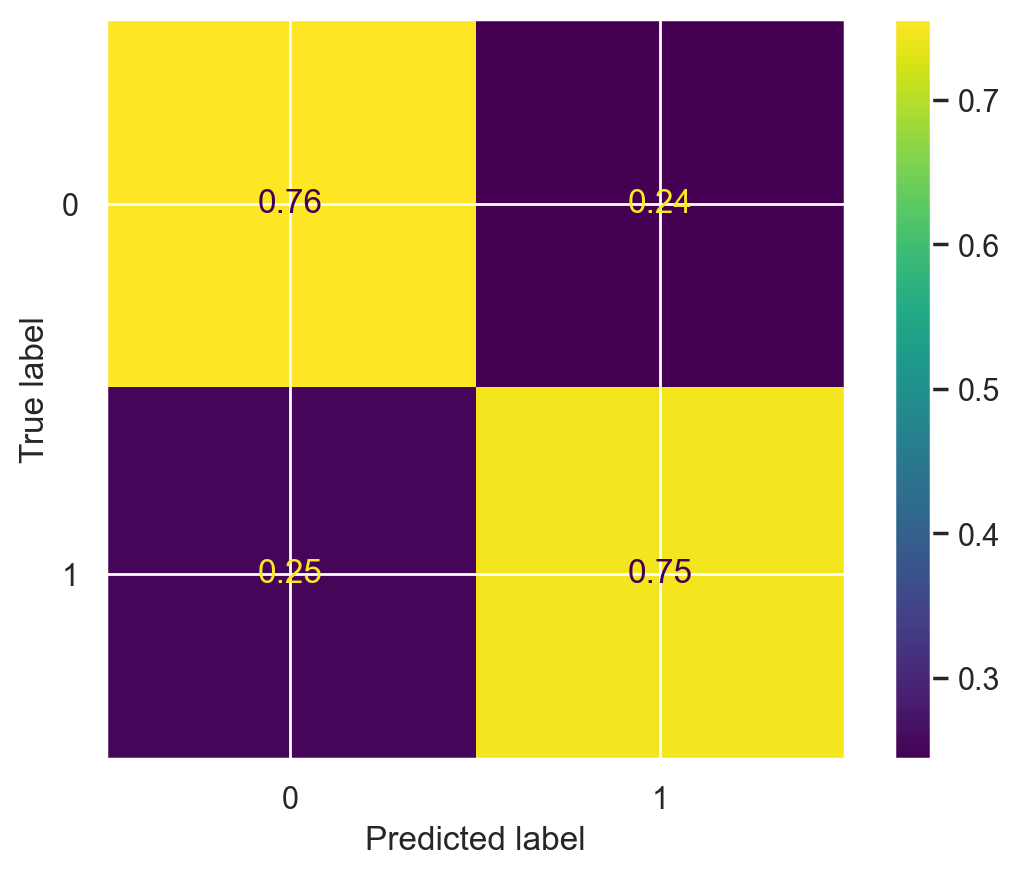

In [17]:
test_predictions = (lr_pipeline.predict_proba(X_test)[:, 1] >= 0.39).astype("int")
plot_confusion_table(y_test, test_predictions)

This classifier's skill is better in peformance than previous ones for reaching true churned customers.